In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data import load_training_data, load_test_data, split_data
import networkx as nx
import time, datetime
from utils import plot_graph
from tqdm import tqdm

from n_walk import product_graph, graph_product, graph_product_el, get_labels_nodes
import kernel_class as kc
import kernel_methods as km
import analysis_kernels as ak

from importlib import reload

In [2]:
graphs, labels =  load_training_data()
submi_graphs = load_test_data()

# Test of graph product

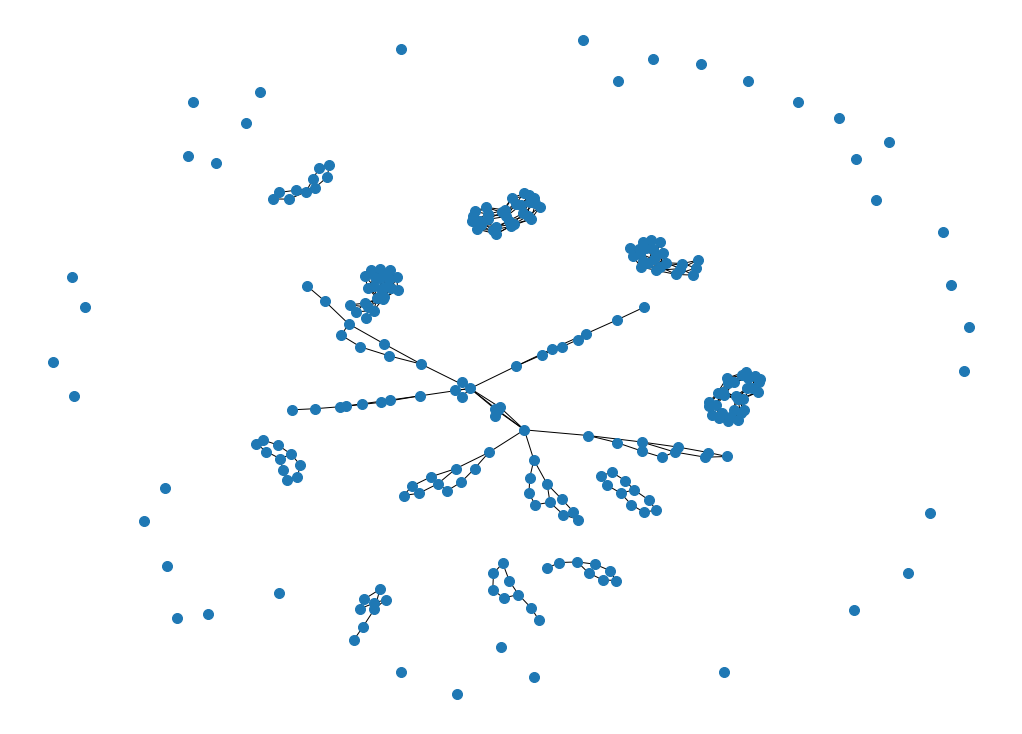

In [3]:
g1, g2 = graphs[:2]
plt.figure(figsize=(14, 10))
gp = product_graph(g1, g2)
nx.draw(gp, node_size = 100)

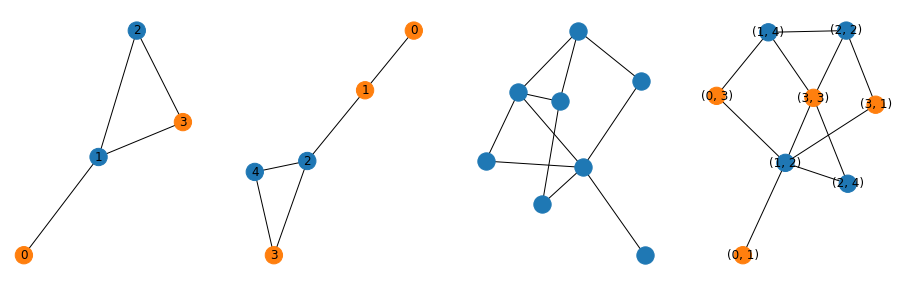

In [13]:
ga = nx.Graph([(0, 1), (1, 2), (1, 3), (2, 3)])
for v, l in zip(range(4), [0, 1, 1, 0]) : ga.nodes[v]["labels"] = [l]
gb = nx.Graph([(0, 1), (1, 2), (2, 3), (3, 4), (4, 2)])
for v, l in zip(range(5), [0, 0, 1, 0, 1]) : gb.nodes[v]["labels"] = [l]

plt.figure(figsize=(20, 5))
plt.subplot(1, 5, 1)
plot_graph(ga)
plt.subplot(1, 5, 2)
plot_graph(gb)
plt.subplot(1, 5, 3)
gp = product_graph(ga, gb)
initial_nodes = dict(gp.nodes)
for v in initial_nodes:
    if len(gp.edges(v))==0:
        gp.remove_node(v)
nx.draw(gp)
plt.subplot(1, 5, 4)
plot_graph(graph_product(ga, gb, with_lonely_nodes=False))

# Test product graph speed

In [14]:
np.random.seed(42)
g1_indices = np.random.choice(len(graphs), 6000, replace=True)
g2_indices = np.random.choice(len(graphs), 6000, replace=True)

def convert_time(seconds_tot):
    seconds = int(seconds_tot%60)
    minutes_tot = int(seconds_tot//60)
    if minutes_tot == 0: return f"{seconds}s"
    minutes = minutes_tot%60
    hours = int(minutes_tot//60)
    if hours == 0: return f"{minutes}m {seconds}s"
    return f"{hours}h {minutes}m {seconds}s"


def test_speed_one_graph(f, *args, **kwargs):
    n_in, n_out = 100, 60
    times_list = []
    for i in range(n_out):
        t0 = time.time()
        for j in range(n_in):
            g = graphs[g1_indices[i*n_in + j]]
            f(g, *args, **kwargs)
        t1 = time.time()
        times_list.append(t1 - t0)
    times_full = np.array(times_list)/n_in * (6000*6001)/2 #time to compute the whole gram matrix
    print(convert_time(times_full.mean()), ", ", convert_time(times_full.std()))
    return times_full

def test_speed_two_graphs(f, *args, preprocess = lambda x : x, **kwargs):
    n_in, n_out = 100, 60
    times_list = []
    pro_graphs1 = [preprocess(graphs[i]) for i in g1_indices]
    pro_graphs2 = [preprocess(graphs[i]) for i in g2_indices]
    for i in range(n_out):
        t0 = time.time()
        for j in range(n_in):
            g1 = pro_graphs1[i*n_in + j]
            g2 = pro_graphs2[i*n_in + j]
            f(g1, g2, *args, **kwargs)
        t1 = time.time()
        times_list.append(t1 - t0)
    times_full = np.array(times_list)/n_in * (6000*6001)/2 #time to compute the whole gram matrix
    print(convert_time(times_full.mean()), ", ", convert_time(times_full.std()))
    return times_full

In [20]:
from n_walk import product_graph, graph_product, graph_product_el
d = test_speed_two_graphs(product_graph)

19h 53m 43s ,  4h 4m 1s


In [21]:
d = test_speed_two_graphs(graph_product)

7h 57m 43s ,  2h 39m 12s


In [22]:
d = test_speed_two_graphs(graph_product, with_lonely_nodes=False)

5h 53m 40s ,  59m 27s


In [23]:
d = test_speed_two_graphs(graph_product_el)

8h 9m 12s ,  2h 54m 24s


In [24]:
d = test_speed_two_graphs(graph_product_el, with_lonely_nodes=False)

4h 41m 6s ,  1h 14m 44s


# Test of Random Walk Kernel and its acceleration.

In [318]:
sub_graphs, sub_labels = split_data(n_splits=3)[0]
souby = sub_graphs[:20]

100%|██████████| 20/20 [00:00<00:00, 21.90it/s]


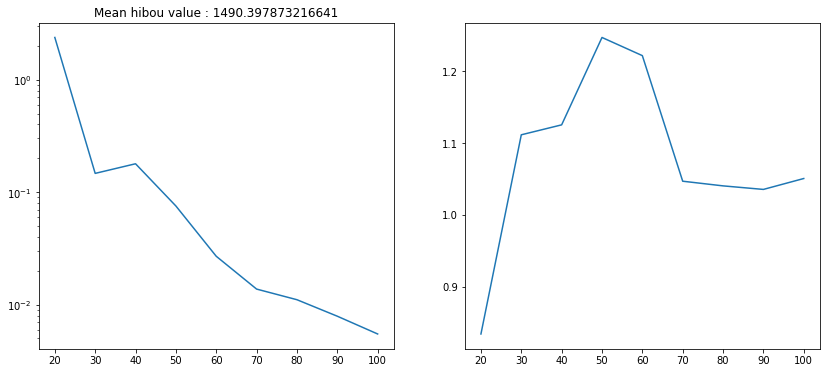

In [341]:
reload(kc)
# chouette = kc.RandomWalkKernelNaive(0.95, norm1=True, norm2=True, exclude_lonely_nodes=False)
hibou    = kc.RandomWalkKernel(0.95, norm1=True, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=False)
hibou_souby = hibou.compute_gram_matrix(souby)

exec_times = []
accur = []
max_iters = range(20, 110, 10)
for max_iter in max_iters:
    aigle    = kc.RandomWalkKernel(0.95, norm1=True, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=True, max_iter=max_iter)
    t0 = time.time()
    aigle_souby = aigle.compute_gram_matrix(souby)
    t1 = time.time()
    exec_times.append(t1-t0)
    accur.append(np.max(np.abs(aigle_souby - hibou_souby)))
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(max_iters, accur)
plt.title(f"Mean hibou value : {np.abs(hibou_souby).mean()}")
plt.yscale('log')
plt.subplot(122)
plt.plot(max_iters, exec_times)


100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


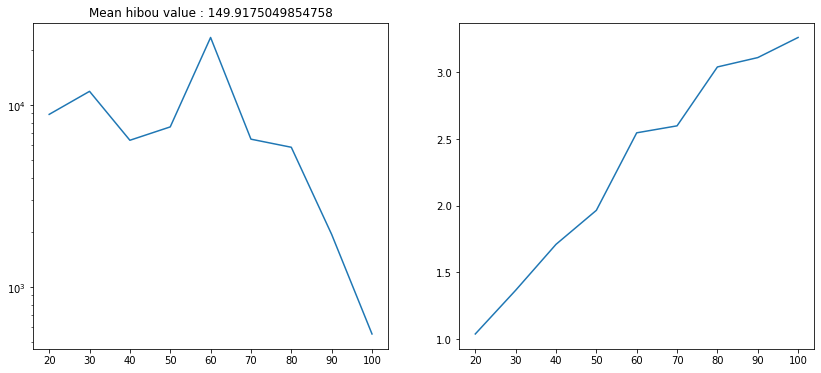

In [343]:
reload(kc)
# chouette = kc.RandomWalkKernelNaive(0.95, norm1=True, norm2=True, exclude_lonely_nodes=False)
hibou    = kc.RandomWalkKernel(0.95, norm1=False, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=False)
hibou_souby = hibou.compute_gram_matrix(souby)

exec_times = []
accur = []
max_iters = range(20, 110, 10)
for max_iter in max_iters:
    aigle    = kc.RandomWalkKernel(0.95, norm1=False, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=True, max_iter=max_iter)
    t0 = time.time()
    aigle_souby = aigle.compute_gram_matrix(souby)
    t1 = time.time()
    exec_times.append(t1-t0)
    accur.append(np.max(np.abs(aigle_souby - hibou_souby)))
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(max_iters, accur)
plt.title(f"Mean hibou value : {np.abs(hibou_souby).mean()}")
plt.yscale('log')
plt.subplot(122)
plt.plot(max_iters, exec_times)

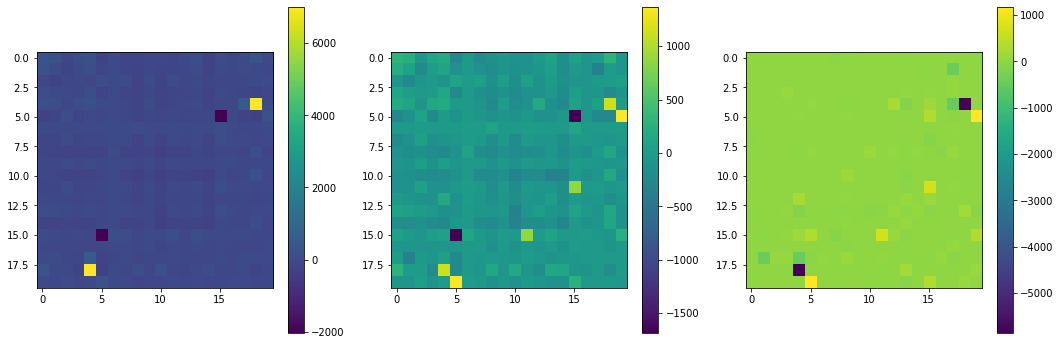

In [335]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(hibou_souby)
plt.colorbar()
plt.subplot(132)
plt.imshow(aigle_souby)
plt.colorbar()
plt.subplot(133)
plt.imshow(aigle_souby - hibou_souby)
plt.colorbar()

# With grakel

In [228]:
from grakel import RandomWalkLabeled, RandomWalk
rwgk = RandomWalkLabeled(lamda=0.95, method_type='fast')
gs = [nx.adjacency_matrix(g).toarray() for g in sub_graphs[:2]]
nls = [[x[0] for x in nx.get_node_attributes(g, "labels").values()] for g in sub_graphs[:2]]
rwgk.fit_transform(zip(gs, nls))

# Computing kernels

In [3]:
split_list, split_idx = split_data(n_splits=3, return_indices=True)
submi_graphs = load_test_data()

sub_graphs, sub_labels = split_list[1]
sub_idx = split_idx[1]
# upper_submi = submi_graphs[:1000]

In [4]:
print(split_idx[0])
print(split_idx[1])
print(split_idx[2])

[   0    2    6 ... 5987 5993 5999]
[   3    5    9 ... 5989 5990 5994]
[   1    4    8 ... 5996 5997 5998]


In [4]:
random_walk_kernel = kc.RandomWalkKernel(lam=0.95, save_kernel=True) #norm1=True, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=True, max_iter=100

In [10]:
# my_outer_gram = random_walk_kernel.compute_outer_gram(upper_submi, sub_graphs, save_suf="3_subsets_1submi_upper")
# now_str = datetime.datetime.now().strftime("%m%d_%H%M%S%f")
# np.save(f"saved/RandomWalkKernel_outer_3_subsets_1submi_{now_str}_idx_submi.npy", upper_submi)
# np.save(f"saved/RandomWalkKernel_outer_3_subsets_1submi_{now_str}_idx_train.npy", sub_graphs)

100%|██████████| 1000/1000 [1:45:05<00:00,  6.31s/it] 


In [5]:
random_walk_kernel = kc.RandomWalkKernel(lam=0.95, save_kernel=False, fast=False) #norm1=True, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=True, max_iter=100

In [ ]:
processed_submi = [random_walk_kernel.filter_graph(g) for g in submi_graphs]

In [7]:
submi_diag = np.zeros((len(processed_submi)))
all_infos = np.zeros((len(processed_submi)), dtype=int)
for i in tqdm(range(len(processed_submi))):
    submi_diag[i], info = random_walk_kernel.kernel_eval(processed_submi[i], processed_submi[i])

100%|██████████| 2000/2000 [19:07<00:00,  1.74it/s]  


In [9]:
np.save("saved/RandomWalkKernel_outer_3_subset_submi_diag.npy", submi_diag)

In [29]:
# from multiprocessing import Pool

# blocs = [
#     (submi_graphs[:10], sub_graphs[:10]),
#     (submi_graphs[:10], sub_graphs[10:20]),
#     (submi_graphs[10:20], sub_graphs[:10]),
#     (submi_graphs[10:20], sub_graphs[10:20])
# ]

# personal_rwk = [kc.RandomWalkKernel(lam = 0.95, save_kernel=True) for i_bloc in range(4)]

# malettes = [t for t in zip(blocs, personal_rwk, np.arange(4))]

# def par_func(malette):
#     submi_list, train_list = malette[0]
#     rwk_perso = malette[1]
#     i_bloc = malette[2]
#     res = rwk_perso.compute_outer_gram(submi_list, train_list)
#     suf = datetime.datetime.now().strftime("%m%d%_h%m%s")
#     # np.save(f'saved/RWK_{suf}_{i_bloc}_idx_submi.npy', submi_list)
#     # np.save(f'saved/RWK_{suf}_{i_bloc}_idx_train.npy', train_list)
#     return res

# with Pool(4) as p:
#     res_svg = p.map(par_func, malettes)

# Kernels correction

In [181]:
split_list, split_idx = split_data(n_splits=3, return_indices=True)
submi_graphs = load_test_data()

sub_graphs, sub_labels = split_list[1]
sub_idx = split_idx[1]

K = np.load("saved/RandomWalkKernel_outer_3_subsets_1submi.npy")

In [183]:
rwk_slow = kc.RandomWalkKernel(lam=0.95, fast=False)
processed_graphs = [rwk_slow.filter_graph(g) for g in sub_graphs]

In [168]:
processed_submi_graphs = [rwk_slow.filter_graph(g) for g in submi_graphs]

In [184]:
K_correct, k_old_list, k_cor_list, k_diff_list = ak.correct_kernel(K, rwk_slow, processed_submi_graphs, processed_graphs)

In [186]:
# np.save("saved/RandomWalkKernel_outer_3_subsets_1submi_corrected.npy", K_correct)

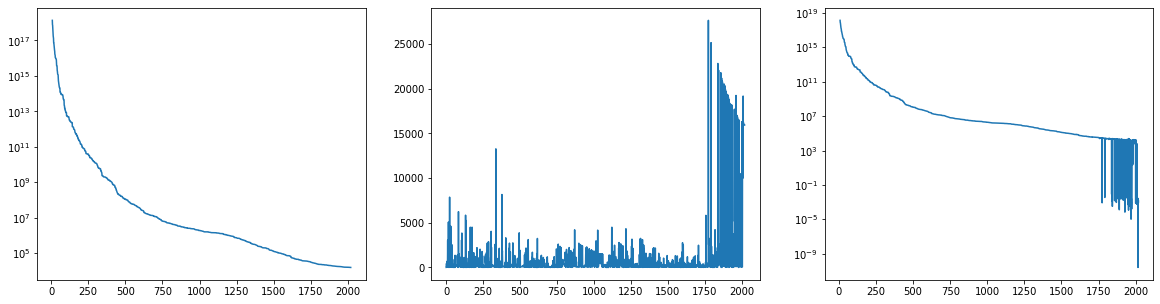

In [185]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(np.abs(k_old_list))
plt.yscale('log')
plt.subplot(132)
plt.plot(k_cor_list)
plt.subplot(133)
plt.plot(np.abs(k_diff_list))
plt.yscale('log')

# Kernel psdfication and normalisation

In [148]:
for i in range(3):
    K = np.load(f"saved/RandomWalkKernel_3_subset_{i}.npy")
    print(np.min(np.linalg.eigvalsh(K)), end="\t")
    K_psd = ak.psdfy(K, 2e-5)
    K_psd_norm = ak.normalize(K_psd)
    print(np.min(np.linalg.eigvalsh(K_psd_norm)), "\t", np.all(K_psd_norm == K_psd_norm.T))
    np.save(f"saved/RandomWalkKernel_3_subset_{i}_psd_norm.npy", K_psd_norm)

-148401.01630173906	6.02175938198619e-10 	 True
-89895.52598855199	8.046593449201106e-10 	 True
-45311.8022718523	1.1476202870611334e-09 	 True


In [13]:
reload(ak)
submi_diag = np.load("saved/RandomWalkKernel_outer_3_subset_submi_diag.npy")
print(submi_diag.shape)
for i in range(3):
    K_outer = np.load(f"saved/RandomWalkKernel_outer_3_subsets_submi{i}.npy")
    K = np.load(f"saved/RandomWalkKernel_3_subset_{i}.npy")
    K_psd = ak.psdfy(K, 2e-5)
    K_diag = K_psd[np.arange(len(K_psd)), np.arange(len(K_psd))]
    K_outer_norm = ak.outer_normalize(K_outer, submi_diag, K_diag)
    np.save(f"saved/RandomWalkKernel_outer_3_subsets_submi{i}_norm.npy", K_outer_norm)

(2000,)


0.9996075

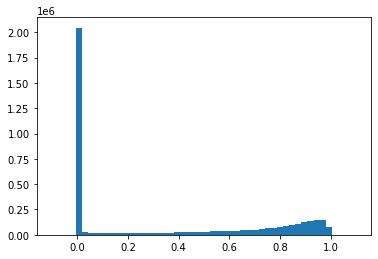

In [33]:
plt.hist(K_outer_norm.flatten(), range=(-0.1, 1.1), bins=50);
np.mean((K_outer >= 0) & (K_outer_norm <= 1))

# SVM Test

In [135]:
reload(km)
split_list, split_idx = split_data(n_splits=3, return_indices=True)
submi_graphs = load_test_data()

sub_graphs, sub_labels = split_list[0]
sub_idx = split_idx[0]


In [145]:
K = np.load("saved/RandomWalkKernel_3_subset_0.npy")
K_psd = ak.psdfy(K, eps=2e-10)
Kpn = ak.normalize(K_psd)
Kpn_plus = ak.normalize(ak.psdfy(K, eps=1))


In [137]:
print(np.linalg.eigvalsh(Kpn).min(), np.all(Kpn == Kpn.T))
print(np.linalg.eigvalsh(Kpn_plus).min(), np.all(Kpn_plus == Kpn_plus.T))

1.8921764025245235e-15 True
2.83079863230424e-05 True


In [35]:
# from cvxopt import matrix
# K = K[:5, :5]
# y = sub_labels[:5]
# N = 5
# c = np.ones((N))/2
# P = matrix(K)
# q = - matrix(y[:,None])
# G = matrix(np.concatenate([-np.diag(y), np.diag(y)], axis=0))
# h = matrix(np.concatenate([np.zeros(N), c]))
# # A = matrix(np.ones((1,N))) # if we want to take the version with b
# A = matrix(np.zeros((1,N)))
# b = matrix(0.)
# print(b)

[ 0.00e+00]



In [138]:
n_sub = 2000
# svm.fit(Kpn_plus[:n_sub, :n_sub], sub_labels[:n_sub])

     pcost       dcost       gap    pres   dres
 0: -3.0198e+02 -5.6407e+00  2e+04  1e+02  1e-14
 1: -1.4276e+01 -1.6488e+00  6e+02  5e+00  1e-14
 2: -5.0117e-01 -1.1035e+00  2e+01  1e-01  1e-15
 3: -1.1785e-01 -9.0817e-01  1e+00  5e-03  2e-15
 4: -9.5981e-02 -3.1730e-01  3e-01  8e-04  6e-15
 5: -9.2165e-02 -1.0362e-01  1e-02  1e-17  2e-15
 6: -9.2448e-02 -9.2783e-02  3e-04  2e-18  6e-16
 7: -9.2478e-02 -9.2615e-02  1e-04  2e-18  3e-16
 8: -9.2480e-02 -9.2615e-02  1e-04  2e-18  3e-16
 9: -9.2490e-02 -9.2580e-02  9e-05  4e-18  2e-16
10: -9.2493e-02 -9.2567e-02  7e-05  2e-18  2e-16
11: -9.2497e-02 -9.2521e-02  2e-05  1e-17  3e-16
12: -9.2498e-02 -9.2518e-02  2e-05  7e-18  2e-16
13: -9.2499e-02 -9.2506e-02  7e-06  8e-18  2e-16
14: -9.2499e-02 -9.2504e-02  5e-06  1e-17  2e-16
15: -9.2500e-02 -9.2501e-02  2e-06  1e-17  3e-16
16: -9.2500e-02 -9.2500e-02  6e-07  1e-17  3e-16
17: -9.2500e-02 -9.2500e-02  3e-07  2e-18  3e-16
18: -9.2500e-02 -9.2500e-02  2e-07  2e-18  3e-16
19: -9.2500e-02 -9.25

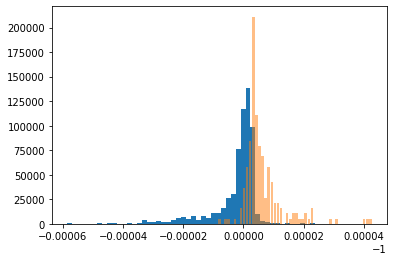

In [141]:
reload(km)
svm = km.KernelSVM2(lmbd=1, balanced=False)
svm.fit(Kpn[:n_sub, :n_sub], sub_labels[:n_sub])
y = svm.predict(Kpn)
y_true = sub_labels
# plt.scatter(y, y_true, c=(y_true + 1)//2, marker="+")
plt.hist(y[y_true < 0], bins=50, density=True)
plt.hist(y[y_true > 0], bins=50, density=True, alpha=0.5, rwidth=0.8);

In [142]:
svm.score(Kpn_plus, y_true, score_type='AUROC')

0.8952989352989353

# Kernel analysis

In [3]:
split_list, split_idx = split_data(n_splits=3, return_indices=True)
submi_graphs = load_test_data()

sub_graphs, sub_labels = split_list[0]
sub_idx = split_idx[0]

K = np.load("saved/RandomWalkKernel_3_subset_0.npy")

In [8]:
y = sub_labels
K_psd = psdwarp(K, eps=1e-8)
# np.max(np.abs(K_psd - K_psd.T))
K_psd = K_psd[:500, :500]
y = y[:500]
np.linalg.eigvalsh(K_psd).min(), np.all(K_psd == K_psd.T)

(9.999619878764318e-09, True)

In [9]:
import cvxpy as cp
alpha = cp.Variable(K_psd.shape[0])
obj = cp.Maximize(2 * alpha.T @ y - cp.quad_form(alpha,K_psd))

In [10]:
obj.args, obj.is_dcp()

ArpackNoConvergence: ARPACK error -1: No convergence (5001 iterations, 0/1 eigenvectors converged)